In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)

df = pd.read_csv("../data/multidimensional.csv")
df.head()

,unit_id,tries_amount,questionnaire_amount,dimensions_amount,document_amount,current_try,q_0_age_question,q_0_age_answer,q_0_age_value,q_0_school_question,q_0_school_answer,q_0_school_value,q_0_taxes_question,q_0_taxes_answer,q_0_taxes_value,q_0_political_views_question,q_0_political_views_answer,q_0_political_views_value,q_0_consideration_question,q_0_consideration_answer,q_0_consideration_value,q_0_southern_border_question,q_0_southern_border_answer,q_0_southern_border_value,q_0_environment_question,q_0_environment_answer,q_0_environment_value,q_0_time_elapsed,q_0_accesses,q_1_farmers_question,q_1_farmers_answer,q_1_farmers_value,q_1_time_elapsed,q_1_accesses,q_2_marks_question,q_2_marks_answer,q_2_marks_value,q_2_time_elapsed,q_2_accesses,q_3_athletics_question,q_3_athletics_answer,q_3_athletics_value,q_3_time_elapsed,q_3_accesses,doc_index,doc_name,doc_statement,doc_claimant,doc_date,doc_originatedFrom,doc_ground_truth_value,doc_ground_truth_abc_label,doc_ground_truth_abc_verdict,doc_ground_truth_politifact_label,doc_source,doc_overall-truthfulness_value,doc_overall-truthfulness_label,doc_overall-truthfulness_justification,doc_overall-truthfulness_url,doc_confidence_value,doc_confidence_label,doc_confidence_justification,doc_confidence_url,doc_correctness_value,doc_correctness_label,doc_correctness_justification,doc_correctness_url,doc_neutrality_value,doc_neutrality_label,doc_neutrality_justification,doc_neutrality_url,doc_comprehensibility_value,doc_comprehensibility_label,doc_comprehensibility_justification,doc_comprehensibility_url,doc_precision_value,doc_precision_label,doc_precision_justification,doc_precision_url,doc_completeness_value,doc_completeness_label,doc_completeness_justification,doc_completeness_url,doc_speaker's-trustworthiness_value,doc_speaker's-trustworthiness_label,doc_speaker's-trustworthiness_justification,doc_speaker's-trustworthiness_url,doc_informativeness_value,doc_informativeness_label,doc_informativeness_justification,doc_informativeness_url,doc_accesses,doc_time_elapsed
0,unit_1,10,4,9,11,1,What is your age range?,26-35,2.0,What is the highest level of school you have c...,"Some college (some community college, associat...",2.0,Last year what was your total family income fr...,"30,000 to less than 40,000",3.0,"In general, would you describe your political ...",Very liberal,4.0,"In politics today, do you consider yourself a",Independent,2.0,Should the U.S. build a wall along the souther...,Disagree,1.0,Should the government increase environmental r...,Agree,0.0,38.6,1,If three farmers can plant three trees in thre...,NaN,1.0,17.98,1,Sean received both the 5th highest and the 5th...,NaN,9.0,23.91,1,"In an athletics team, females are four times m...",NaN,4.0,274.19,1,0.0,Liberal_In_Between_doc1,What the states do is a matter for the states ...,Tony Abbott,2013.0,NaN,3.0,in-between,lawyer's picnic,NaN,abc,1.0,agree,NaN,https://www.thenewamerican.com/usnews/constitu...,-1.0,disagree,NaN,NaN,1.0,agree,NaN,NaN,1.0,agree,NaN,NaN,1.0,agree,NaN,NaN,1.0,agree,NaN,NaN,-1.0,disagree,NaN,NaN,0.0,neither-agree-nor-disagree,NaN,NaN,1.0,agree,NaN,NaN,1.0,175.61
1,unit_1,10,4,9,11,1,What is your age range?,26-35,2.0,What is the highest level of school you have c...,"Some college (some community college, associat...",2.0,Last year what was your total family income fr...,"30,000 to less than 40,000",3.0,"In general, would you describe your political ...",Very liberal,4.0,"In politics today, do you consider yourself a",Independent,2.0,Should the U.S. build a wall along the souther...,Disagree,1.0,Should the government increase environmental r...,Agree,0.0,38.6,1,If three farmers can plant three trees in thre...,NaN,1.0,17.98,1,Sean received both the 5th highest and the 5th...,NaN,9.0,23.91,1,"In an athletics team, females are four times m...",NaN,4.0,274.19,1,1.0,Labor_Negative_doc3,Mr Abbott seems to be suffering from just a li...,Kevin Rudd,2013.0,NaN,4.0,negative,wrong,NaN,abc,2.0,completely-agree,NaN,https://

In [2]:
# compute CRT scores
q1_value = df["q_1_farmers_value"]
q1_score = (q1_value == 3.0).astype("int")
df["q_1_farmers_score"] = q1_score

q2_value = df["q_2_marks_value"]
q2_score = (q2_value == 9.0).astype("int")
df["q_2_marks_score"] = q2_score

q3_value = df["q_3_athletics_value"]
q3_score = (q3_value == 16.0).astype("int")
df["q_3_athletics_score"] = q3_score

df.to_csv("../data/multidimensional_with_crt.csv", index=False)

In [3]:
worker_data = df[[
    "unit_id",
    "q_0_age_value", 
    "q_0_school_value", 
    "q_0_taxes_value", 
    "q_0_political_views_value", 
    "q_0_consideration_value", 
    "q_0_southern_border_value", 
    "q_0_environment_value", 
    "q_1_farmers_score", 
    "q_2_marks_score", 
    "q_3_athletics_score", 
]]
worker_data = worker_data.drop_duplicates()
worker_data["doc_assessment_mse"] = 0.0
worker_data = worker_data.set_index("unit_id")
worker_data = (worker_data - worker_data.min()) / (worker_data.max() - worker_data.min())
worker_data.shape

(200, 11)

#### Hypothesis
Reliable workers intend to show a lower mean square error on their assessment of the statements.

#### To test
If there are any correlation between the work profile data and the mse score of their assessment.

In [4]:
# compute variance between ground truth and assessments
worker_groups = df.groupby(by="unit_id")
for worker, group in worker_groups:
    truth = group["doc_ground_truth_value"]
    assessment = group["doc_overall-truthfulness_value"]
    mse = mean_squared_error(truth, assessment)
    worker_data.loc[worker, "doc_assessment_mse"] = mse
worker_data.describe()

,q_0_age_value,q_0_school_value,q_0_taxes_value,q_0_political_views_value,q_0_consideration_value,q_0_southern_border_value,q_0_environment_value,q_1_farmers_score,q_2_marks_score,q_3_athletics_score,doc_assessment_mse
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.391667,0.521250,0.536875,0.561250,0.330000,0.33250,0.105000,0.500000,0.295000,0.075000,5.315000
std,0.280459,0.275436,0.247410,0.312529,0.258825,0.29772,0.268019,0.501255,0.457187,0.264052,2.168317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.636364
25%,0.333333,0.437500,0.375000,0.250000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,3.909091
50%,0.333333,0.500000,0.500000,0.500000,0.333333,0.50000,0.000000,0.500000,0.000000,0.000000,4.818182
75%,0.666667,0.500000,0.750000,0.750000,0.666667,0.50000,0.000000,1.000000,1.000000,0.000000,6.386364
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,16.727273


<AxesSubplot:>

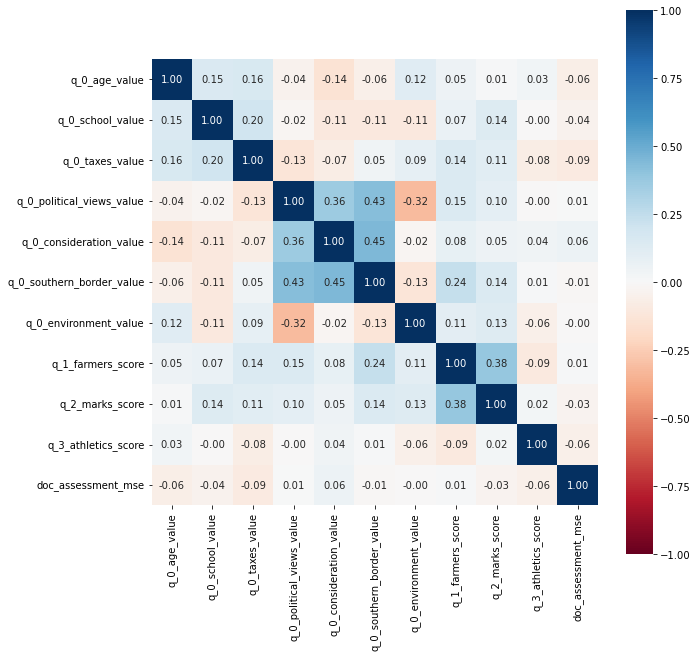

In [5]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    data=worker_data.corr(method="spearman"),  # pearson and kendall also give similar results
    cmap="RdBu", 
    vmin=-1, 
    vmax=1, 
    square=True, 
    annot=True, 
    fmt=".2f"
)

#### Categorical independent variables encoding
[Here](https://stats.oarc.ucla.edu/spss/faq/coding-systems-for-categorical-variables-in-regression-analysis-2/) is a link of different encoding methods. In our case, simple encoding is applied, but this could be improved, since for some of the columns (e.g. political view and consideration), the values doesn't have to be ordinal.

In [32]:
# machine learning tasks setup
X = worker_data[[
    "q_0_age_value", 
    "q_0_school_value", 
    "q_0_taxes_value", 
    "q_0_political_views_value", 
    "q_0_consideration_value", 
    "q_0_southern_border_value", 
    "q_0_environment_value", 
    "q_1_farmers_score", 
    "q_2_marks_score", 
    "q_3_athletics_score", 
]]
y = worker_data["doc_assessment_mse"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_basic = X_train[[
    "q_0_age_value", 
    "q_0_school_value", 
    "q_0_taxes_value", 
]]
X_train_policical = X_train[[
    "q_0_political_views_value", 
    "q_0_consideration_value", 
    "q_0_southern_border_value", 
    "q_0_environment_value", 
]]
X_train_crt = X_train[[
    "q_1_farmers_score", 
    "q_2_marks_score", 
    "q_3_athletics_score", 
]]
kfold = KFold(n_splits=10)

In [33]:
# model selection
model_lr = LinearRegression()
model_rfr = RandomForestRegressor()
model_dtr = DecisionTreeRegressor()
model_gpr = GaussianProcessRegressor()
model_svr = SVR()

def model_comparision(X, y):
    results_lr = cross_val_score(model_lr, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
    results_rfr = cross_val_score(model_rfr, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
    results_dtr = cross_val_score(model_dtr, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
    results_gpr = cross_val_score(model_gpr, X, y, cv=kfold, scoring='neg_root_mean_squared_error')
    results_svr = cross_val_score(model_svr, X, y, cv=kfold, scoring='neg_root_mean_squared_error')


    print("RMSE lr: %.3f (+/-%.3f)" % (-results_lr.mean(), results_lr.std()))
    print("RMSE rfr: %.3f (+/-%.3f)" % (-results_rfr.mean(), results_rfr.std()))
    print("RMSE dtr: %.3f (+/-%.3f)" % (-results_dtr.mean(), results_dtr.std()))
    print("RMSE gpr: %.3f (+/-%.3f)" % (-results_gpr.mean(), results_gpr.std()))
    print("RMSE svr: %.3f (+/-%.3f)" % (-results_svr.mean(), results_svr.std()))
    print()

print("X_all:")
model_comparision(X=X_train, y=y_train)
print("X_basic:")
model_comparision(X=X_train_basic, y=y_train)
print("X_policical:")
model_comparision(X=X_train_policical, y=y_train)
print("X_crt:")
model_comparision(X=X_train_crt, y=y_train)

X_all:
RMSE lr: 2.296 (+/-0.619)
RMSE rfr: 2.464 (+/-0.667)
RMSE dtr: 3.266 (+/-0.867)
RMSE gpr: 5.112 (+/-0.575)
RMSE svr: 2.337 (+/-0.678)

X_basic:
RMSE lr: 2.212 (+/-0.678)
RMSE rfr: 2.610 (+/-0.568)
RMSE dtr: 2.861 (+/-0.565)
RMSE gpr: 10.217 (+/-6.889)
RMSE svr: 2.253 (+/-0.699)

X_policical:
RMSE lr: 2.204 (+/-0.676)
RMSE rfr: 2.349 (+/-0.728)
RMSE dtr: 2.516 (+/-0.814)
RMSE gpr: 4.378 (+/-2.067)
RMSE svr: 2.251 (+/-0.688)

X_crt:
RMSE lr: 2.236 (+/-0.712)
RMSE rfr: 2.230 (+/-0.729)
RMSE dtr: 2.230 (+/-0.736)
RMSE gpr: 2.230 (+/-0.736)
RMSE svr: 2.271 (+/-0.764)



Text(0.5, 0, 'Permutation Feature Importance')

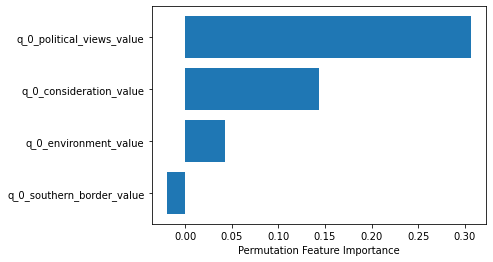

In [34]:
# plot of feature importance
X_test_political = X_test[[
    "q_0_political_views_value", 
    "q_0_consideration_value", 
    "q_0_southern_border_value", 
    "q_0_environment_value", 
]]

model_lr.fit(X_train_policical, y_train)
perm_importance = permutation_importance(model_svr_optimal, X_test_political, y_test)
sort_index = perm_importance.importances_mean.argsort()
plt.barh(X_train_policical.columns.astype("string")[sort_index], perm_importance.importances_mean[sort_index])
plt.xlabel("Permutation Feature Importance")